In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import imageio
from tqdm.notebook import tqdm
import time
import numba as nb
plt.ion()
%matplotlib notebook

In [2]:
def get_kernel(n,r0):
    x=np.fft.fftfreq(n)*n
    rsqr=np.outer(np.ones(n),x**2)
    rsqr=rsqr+rsqr.T
    rsqr[rsqr<r0**2]=r0**2
    kernel=rsqr**-0.5
    return kernel

@nb.njit(parallel = True) 
def get_grid_idx(pos,grid_sidelength):
    grididxs = np.zeros((len(pos),2))
    if np.ptp(pos[:,0])==0:
        xtpt = 1
    else:
        xptp = np.ptp(pos[:,0])
        
    if np.ptp(pos[:,1])==0:
        yptp = 1
    else:
        yptp = np.ptp(pos[:,1])
        
    for i in nb.prange(len(pos)):
        xy = pos[i]
        xgrid = int(grid_sidelength*(xy[0]-np.min(pos[:,0]))/xptp)
        if xgrid == grid_sidelength:
            xgrid-=1
        ygrid = int(grid_sidelength*(xy[1]-np.min(pos[:,1]))/yptp)
        if ygrid == grid_sidelength:
            ygrid-=1
        grididxs[i] = [xgrid,ygrid]
        
   
    return grididxs

@nb.njit(parallel = True)        
def get_rho_2(gridpos,grid_sidelength,rho,masses):
    for  i in nb.prange(len(gridpos)):
        rho[gridpos[i,0],gridpos[i,1]]+=masses[i]
    return rho

@nb.njit(parallel = True)        
def get_grad(pot,gridpos,grid_sidelength,grad):
    for  i in nb.prange(len(gridpos)):
        
        ix,iy = gridpos[i][0],gridpos[i][1]
        
        if ix == 0:
            ix1 = grid_sidelength-1
            ix2 = ix+1
        else:
            ix1 = ix-1
            ix2 = ix+1
            
        if iy == 0:
            iy1 = grid_sidelength-1
            iy2 = iy+1
        else:
            iy1 = iy-1
            iy2 = iy+1
        if ix == grid_sidelength:
            ix1 = ix-1
            ix2 = 0
        else:
            ix1 = ix-1
            ix2 = ix+1
        if iy == grid_sidelength:
            iy1 = iy-1
            iy2 = 0
        else:
            iy1 = iy-1
            iy2 = iy+1
        grad[i][0] = 0.5*(pot[ix2,iy]-pot[ix1,iy])
        grad[i][1] = 0.5*(pot[ix,iy2]-pot[ix,iy1])
    return grad

class Particles:
    def __init__(self,npart = 40000,n = 100,ndim = 2,periodic = True,soft = 1):
        self.npart = npart
        self.x = np.empty([npart,ndim])
        self.gridx = np.empty([npart,ndim])
        self.v = np.empty([npart,ndim])
        self.grad = np.empty([npart,ndim])
        self.f = np.empty([npart,ndim])
        self.ngrid=n
        self.masses = np.ones(self.npart)
        self.soft = soft
        self.periodic = periodic
        self.kernel = None
        self.kernelft = None
        self.init_xbounds = None
        self.init_ybounds = None
        self.timer = False
        self.time_pot = []
        self.time_forces = []
        self.time_plot = []
        
        if periodic:
            self.rho=np.zeros([self.ngrid,self.ngrid])
            self.pot=np.empty([self.ngrid,self.ngrid])
        else:
            self.rho=np.zeros([2*self.ngrid,2*self.ngrid])
            self.pot=np.zeros([2*self.ngrid,2*self.ngrid])
        
    def get_rho(self):
        if self.periodic:
            self.rho=np.histogram2d(self.x[:,0],self.x[:,1],bins = self.ngrid,range = ([np.min(self.x[:,0])
                                                                            ,np.max(self.x[:,0])],[np.min(self.x[:,1])
                                                                            ,np.max(self.x[:,1])]),weights = self.masses)[0]
        else:
            self.rho[self.ngrid//2:3*self.ngrid//2,self.ngrid//2:3*self.ngrid//2] = np.histogram2d(self.x[:,0],self.x[:,1]
                                                                            ,bins = self.ngrid,range = ([np.min(self.x[:,0])
                                                                            ,np.max(self.x[:,0])],[np.min(self.x[:,1])
                                                                          ,np.max(self.x[:,1])]),weights = self.masses)[0]
    def get_rho_numba(self):
        self.gridx = get_grid_idx(self.x,self.ngrid).astype(int)
        densitygrid = get_rho_2(self.gridx,self.ngrid,self.rho,self.masses)
        self.rho = densitygrid
        
    
    def IC_Gauss(self,n_blobs = 1,center_loc = [[0,0]],stds=[1,1]):
        if n_blobs!=len(center_loc) or n_blobs!=len(center_loc):
            print('Need to specify center and std of each blob')
            
        to_remove = self.npart%n_blobs
        self.npart-=to_remove
        parts_per_blob = self.npart//n_blobs
        
        for i in range(n_blobs):
            self.x[i*parts_per_blob:(i+1)*parts_per_blob] = np.random.normal(center_loc[i],stds[i],np.shape(self.x[:parts_per_blob]))
        
        self.init_xbounds = [np.min(self.x[:,0]),np.max(self.x[:,0])]
        self.init_ybounds = [np.min(self.x[:,1]),np.max(self.x[:,1])]
        
    def IC_box(self,xymin = [-1,-1],xymax = [1,1]):
        self.x = np.random.uniform(xymin,xymax,size = np.shape(self.x))
        
    def get_kernel(self):
        if self.periodic:
            self.kernel=get_kernel(self.ngrid,self.soft)
        else:
            self.kernel=get_kernel(2*self.ngrid,self.soft)
        self.kernelft=np.fft.rfft2(self.kernel)
        
    def get_potential(self):
        if self.timer:
            t1 = time.time()
        self.get_rho()
        self.get_kernel()
        rhoft = np.fft.rfft2(self.rho)
        conv = np.fft.irfft2(self.kernelft*rhoft)
        self.pot = conv
        t2 = time.time()
        if self.timer:
            t2 = time.time()
            self.time_pot.append(t2-t1)
    
    def get_forces(self):
        if self.timer:
            t1 = time.time()
        gradx = 0.5*(np.roll(self.pot,1,0)-np.roll(self.pot,-1,0))
        grady = 0.5*(np.roll(self.pot,1,1)-np.roll(self.pot,-1,1))
        self.gridx = get_grid_idx(self.x,self.ngrid).astype(int)
        if not self.periodic:
            self.gridx+=self.ngrid//2
        for i in range(len(self.gridx)):
            self.f[i] = [-gradx[self.gridx[i,0],self.gridx[i,1]],-grady[self.gridx[i,0],self.gridx[i,1]]]
        if self.timer:
            t2 = time.time()
            self.time_forces.append(t2-t1)
            
    def take_step(self,dt=1):
        self.x[:]=self.x[:]+dt*self.v
        self.get_potential()
        self.get_forces()
        self.v[:]=self.v[:]+self.f*dt
    
    def plot_particles(self,density=False,savepath = ''):
        if self.timer:
            t1 = time.time()
        if density:
            plt.figure()
            plt.imshow(np.rot90(self.rho),cmap = 'plasma')
        else:
            plt.figure()
            plt.plot(self.x[:,0],self.x[:,1],'.')
        if savepath !='':
            plt.savefig(savepath)
        if self.timer:
            t2 = time.time()
            self.time_plot.append(t2-t1)
            
    def plot_potential(self):
        plt.figure()
        self.get_potential()
        plt.imshow(np.rot90(particles.pot),cmap = 'plasma')
            
    def timing_report(self):
        avg_pot_time = np.mean(self.time_pot)
        avg_f_time = np.mean(self.time_forces)
        avg_plot_time = np.mean(self.time_plot)
        
        print('With {} particles and grid sidelength {}\n'.format(self.npart,self.ngrid))
        print('Average time to compute potential: {} s'.format(round(avg_pot_time,5)))
        print('Average time to compute forces: {} s'.format(round(avg_f_time,5)))
        print('Average time to plot: {} s'.format(round(avg_plot_time,5)))
        
    def update_removing(self):
        self.masses = np.ones(len(self.x))
        self.v = np.zeros((len(self.x),2))
        self.f = np.zeros((len(self.x),2))

In [37]:
particles = Particles(npart = 2,n=100,periodic = False)
# particles.IC_box([-5,-5],[5,5])
# todel = np.where(np.sum(particles.x**2,axis = 1)<0.5)
# particles.x = np.delete(particles.x,todel,axis = 0)
# todel = np.where(np.sum(particles.x**2,axis = 1)>4)
# particles.x = np.delete(particles.x,todel,axis = 0)
# particles.update_removing()
# particles.timer = True
particles.x = np.array([[1,0],[-1,0]])

<IPython.core.display.Javascript object>


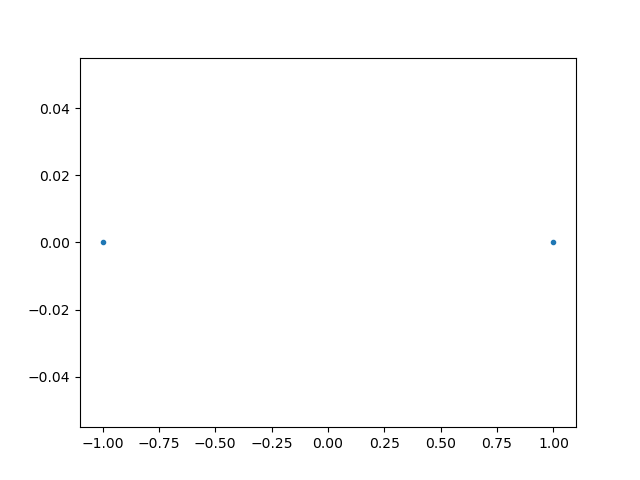

In [38]:
# particles.IC_Gauss(5,np.random.randint(-5,5,size = (5,2)),[0.5,]*5)
# particles.x = np.random.uniform([-1,-1],[1,1],size = np.shape(particles.x))
# particles.IC_box(bounds = [[-2,2],[-2,2]])
# particles.x[len(particles.x)//2:] = np.random.normal([5,5],0.01,size = np.shape(particles.x[len(particles.x)//2:]))
# particles.x = np.array([[-1,0],[1,0]])
particles.v = np.random.normal(size = np.shape(particles.x))
particles.plot_particles()

<IPython.core.display.Javascript object>


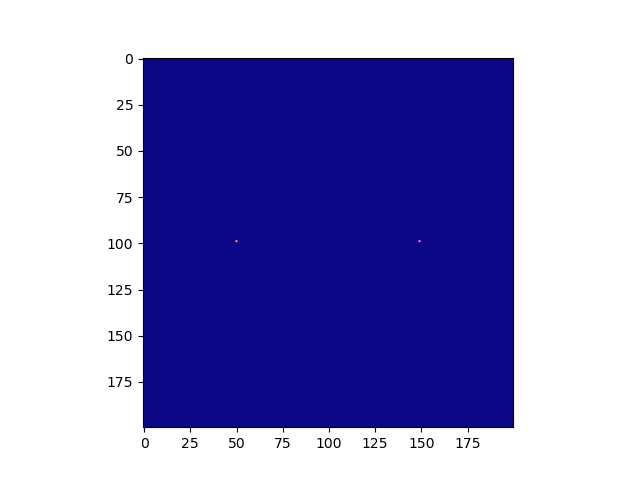

In [39]:
particles.get_rho()
particles.plot_particles(density=True)

<IPython.core.display.Javascript object>


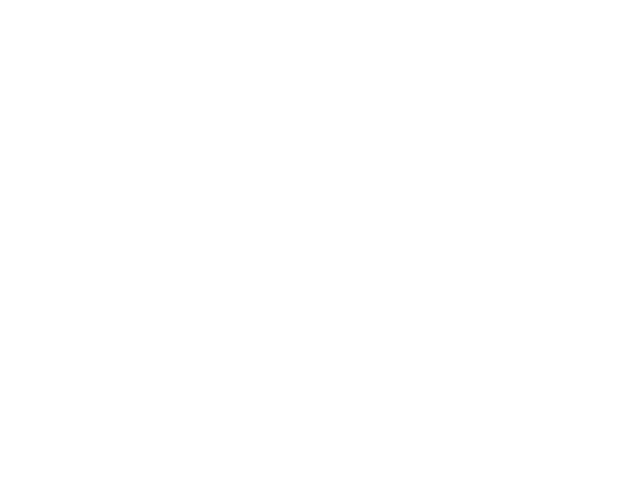

In [40]:
particles.plot_potential()

In [41]:
# particles.get_forces()
# particles.f,particles.gridx

In [46]:
def make_animation(particles,niter,dt = 0.08):
    plt.clf()
    plt.ioff()
    path = 'Figures/Animation_{}_particles_{}_iter/'.format(particles.npart,niter)
    try:
        os.mkdir(path)
    except:
        None
        
    particles.plot_particles(density = False,savepath =path+'%04d'%0 )
    
    for i in tqdm(range(niter)):
        particles.take_step(dt = dt)
        particles.plot_particles(density = False,savepath = path+'%04d'%i)
        plt.close()
    images = []
    filenames = os.listdir(path)
    for filename in filenames:
        images.append(imageio.imread(path+filename))
    imageio.mimsave(path+'{}_particles_{}_iter.gif'.format(particles.npart,niter), images)
    plt.ion()

In [48]:
make_animation(particles,100,dt = 1)

In [49]:
particles.timing_report()

With 2 particles and grid sidelength 100

Average time to compute potential: nan s
Average time to compute forces: nan s
Average time to plot: nan s


C:\Users\miara\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miara\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
particles.f

array([[-7.25674619e-05,  4.36805877e-04],
       [ 7.25674619e-05,  4.36805877e-04]])